<h1 style="font-weight: 300;font-size: 39px;"> Patients sub-group detection by clustering of the W disatnce of Pancreas data and ranking important cells/genes based on found sub-group</h1>

In this tutorial, we are using single-cell data from pancreatic ductal adenocarcinomas to find sub-groups of patients using clustering of W distances. And then we rank the cells/genes based on clustering results.

We first load our packages to use its functions:

In [1]:
from PILOT import *

Next, we load the data wich h5ad format:

In [2]:
#Indicate the path of PDAC data. Please check the manuscript for the dataset
adata=load_h5ad('Datasets/Peng_PDAC_processed.h5ad')

In [3]:
#name_dataset: name of your data ,PILOT creates a folder with this name for saving the whole generated results 
data,annot,path_to_results=extract_data_anno_scRNA_from_h5ad(adata,emb_matrix='X_pca',clusters_col='cell_types',sample_col='sampleID',status='status' ,name_dataset='Pancreas')

We compute each cell type proportion to see how the distribution of cell types changes through each patients sub-groups as disease progress

In [4]:
proportions = Cluster_Representations(annot)

First, we need to find the distances of clusters which shows how one cell type orient to another. This is done by using optimal transport method.

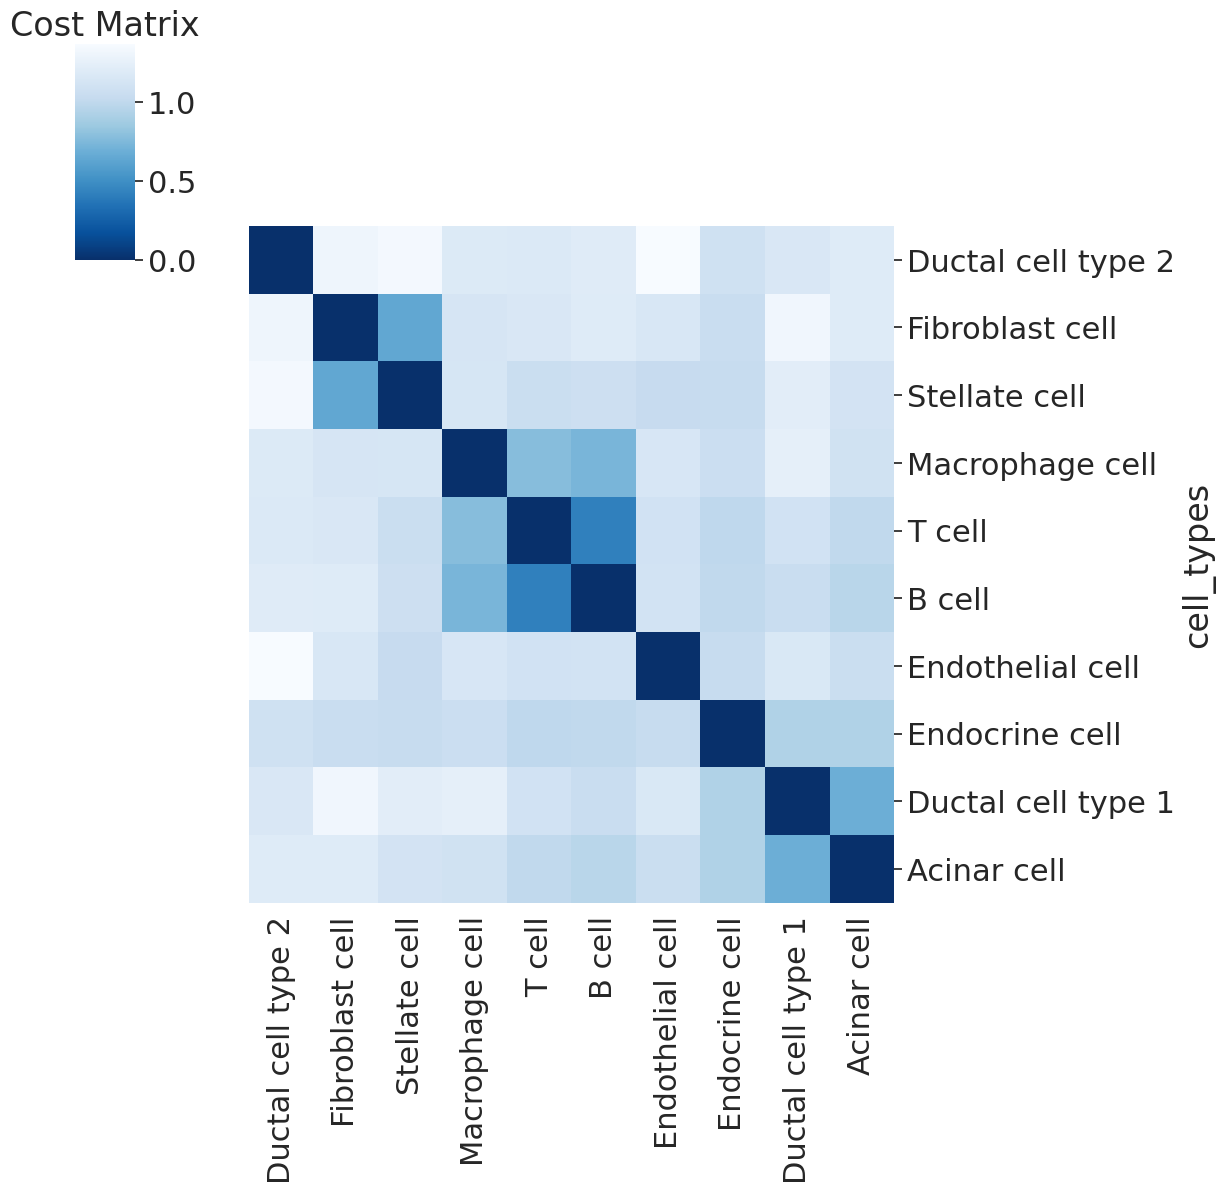

In [5]:
cost = cost_matrix(annot, data, path_to_results)

Using Wasserstein distance, we can compute the distances of samples to measure the cost to have the same condition as another patient.

Cluster labels:  ['T', 'N']
Categories (2, object): ['N', 'T']
ARI:  1.0


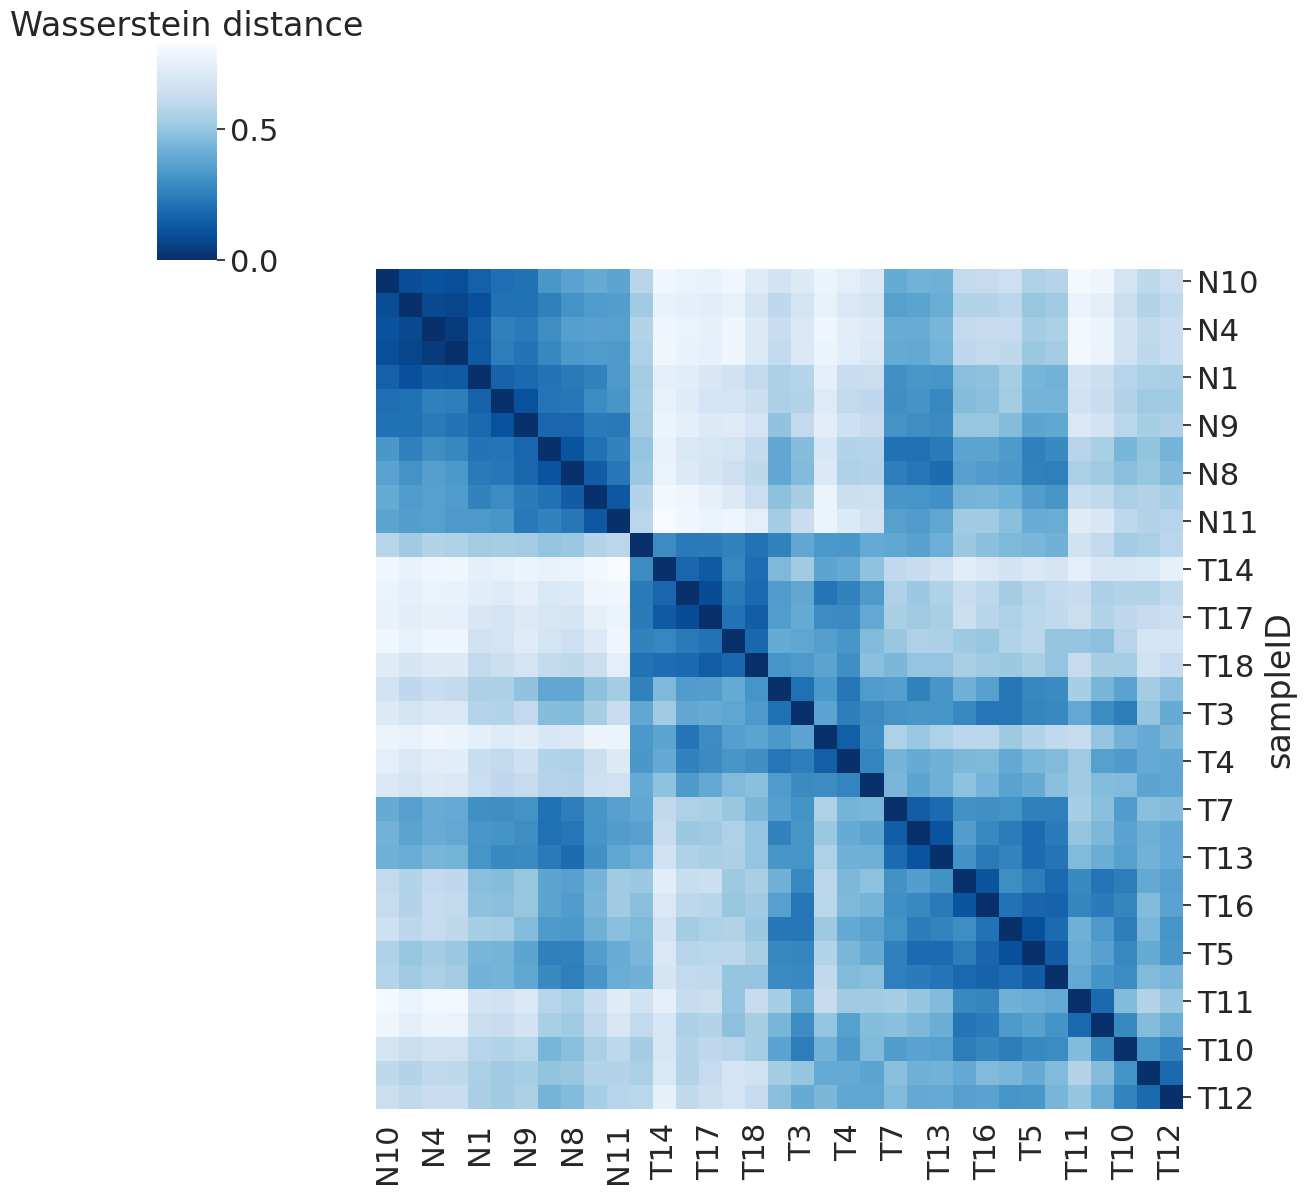

In [6]:
EMD = wasserstein_d(proportions, cost/cost.max(), path = path_to_results)
#Computing clusters and then ARI
predicted_labels, ARI, real_labels = Clustering(EMD/EMD.max(), annot)


<h2 style="font-weight: 300;font-size: 32px;"> Patients sub-group detection by clustering EMD</h2>
Using Silhouette score, we can the find the optimal number of cluster of patients to detect different stage of disease 


Silhouette score:  0.6598408926353901


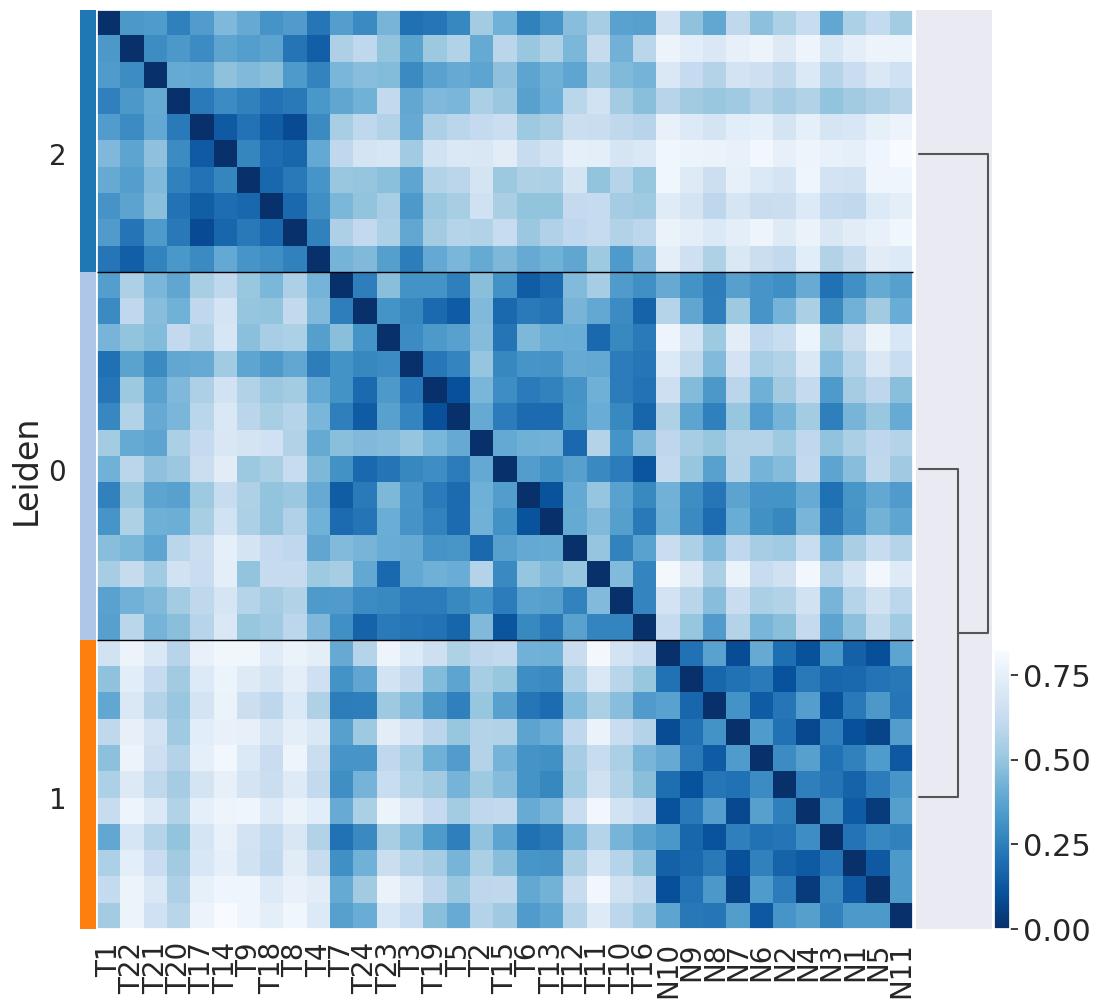

In [7]:
proportion_df=clustering_EMD(EMD,proportions,annot,real_labels,groupby_col='Leiden',show_gene_labels=True)

In [8]:
proportion_df

,Fibroblast cell,Stellate cell,Macrophage cell,Endothelial cell,T cell,B cell,Ductal cell type 2,Endocrine cell,Ductal cell type 1,Acinar cell,Predicted_Labels,sampIeD
T1,0.037589,0.113576,0.105891,0.274959,0.046117,0.015377,0.367178,0.039278,0.000031,0.000006,2,T1
T2,0.023683,0.050644,0.080895,0.079913,0.219654,0.366306,0.053610,0.000658,0.103918,0.020718,0,T2
T3,0.111619,0.223975,0.153370,0.133641,0.069095,0.012913,0.290039,0.004557,0.000786,0.000006,0,T3
T4,0.075958,0.093477,0.100291,0.050654,0.184007,0.073023,0.402102,0.009737,0.007823,0.002928,2,T4
T5,0.050237,0.194602,0.181150,0.265452,0.052019,0.000905,0.087912,0.020626,0.127364,0.019734,0,T5
T6,0.028871,0.115979,0.132011,0.214852,0.036881,0.005349,0.155536,0.017102,0.259211,0.034207,0,T6
T7,0.042859,0.203452,0.042852,0.155289,0.024106,0.002689,0.183404,0.001341,0.309202,0.034807,0,T7
T8,0.012943,0.054532,0.121944,0.030166,0.077470,0.017225,0.674181,0.000003,0.010092,0.001445,2,T8
T9,0.270590,0.036114,0.058202,0.002137,0.005952,0.000004,0.596398,0.002550,0.026351,0.001702,2,T9
T10,0.025385,0.311543,0.071262,0.153383,0.169056,0.152148,0.111132,0.002418,0.002458,0.001216,0,T10


Here we can see that whole of the Normal samples are in cluster 1, so we can rename the name of clusters for future analysis. This step is optional!

In [9]:
proportion_df.loc[proportion_df['Predicted_Labels']=='0', 'Predicted_Labels'] = 'Tumor 1'
proportion_df.loc[proportion_df['Predicted_Labels']=='1', 'Predicted_Labels'] = 'Normal'
proportion_df.loc[proportion_df['Predicted_Labels']=='2', 'Predicted_Labels'] = 'Tumor 2'

Next, we can check the distribution of each patient sub-group in each cell type

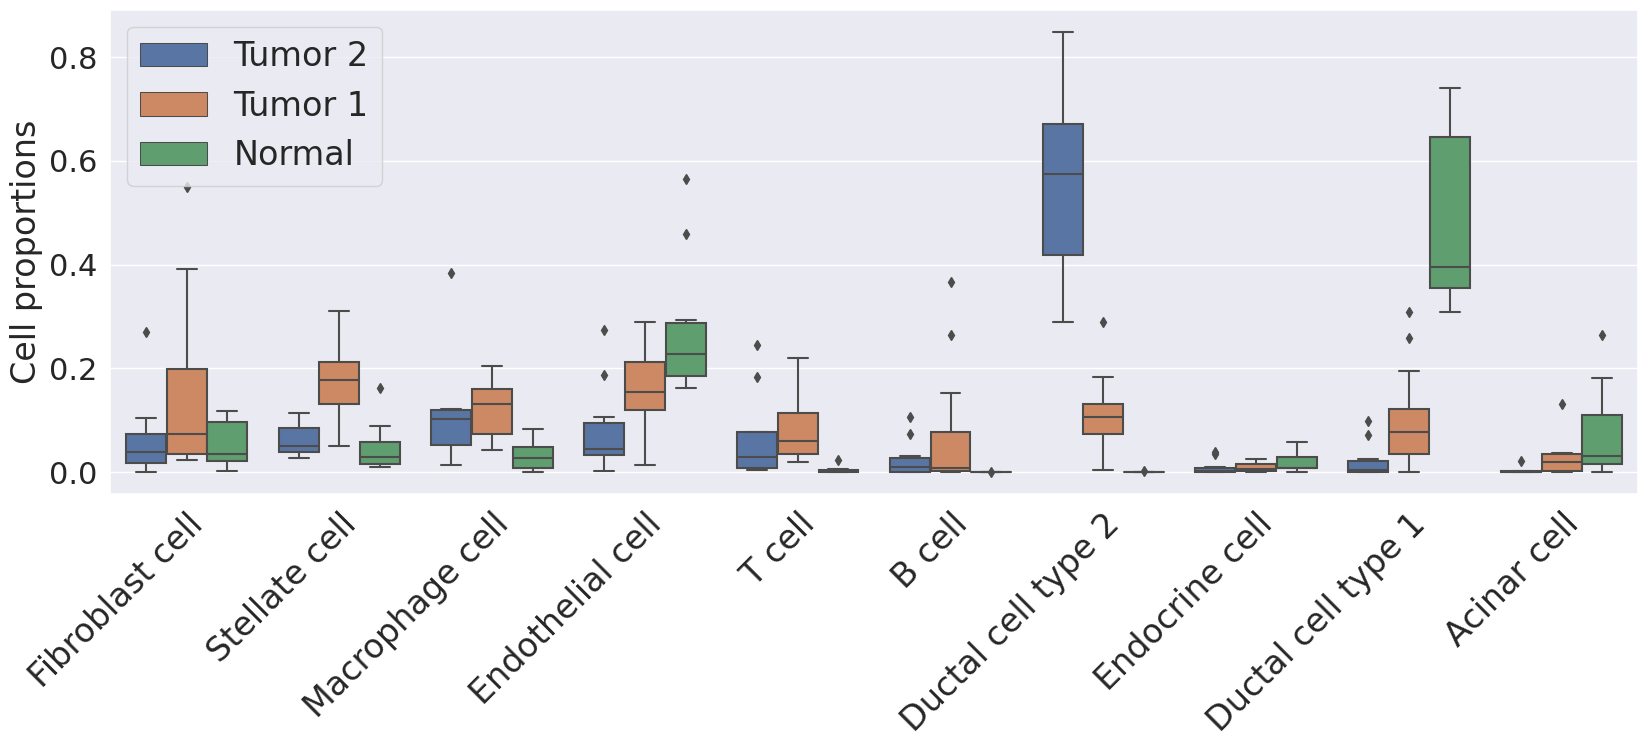

In [10]:
plot_cell_types_distributions(proportion_df, proportion_df.columns[0:-2],
                              file_path = path_to_results, figsize = (17,8))

<h2 style="font-weight: 300;font-size: 32px;"> Cell-type selection</h2>

Importantly, we determine which cell type derives the disease from the first stage to the second stage by detecting cell types having statistically significant changes between two sub-groups. This is done using Welch’s t-test, which is appropriate for unequal variances in two groups of samples.

Based on the adjusted p-value threshold you consider, you can choose how statistically significant the cell types you want to have.

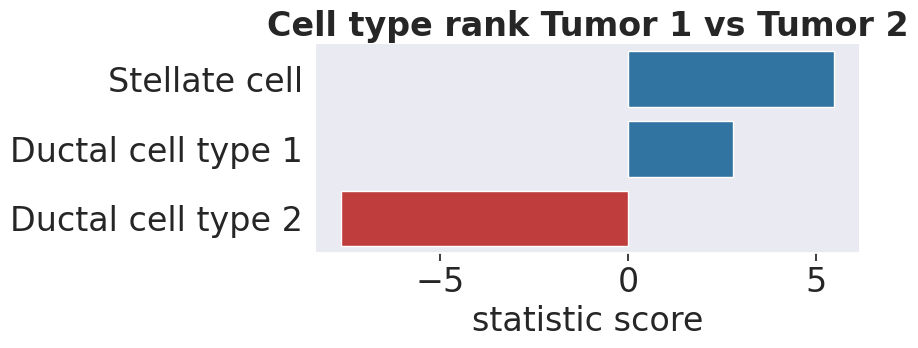

In [11]:
cell_type_diff_two_sub_patient_groups(proportion_df, proportion_df.columns[0:-2],
                                      group1 = 'Tumor 1', group2 = 'Tumor 2',
                                      pval_thr = 0.05, figsize = (15, 4), file_path = path_to_results)

In the statistical table generated in your results path, all cell types sorted based on the score and their adjusted p-value.
cell types with positive scores shows the most differences cell types in group 1 compared with group 2 and negative scores shows the other way.

In [12]:
celltypes_stats_group12 = pd.read_csv(path_to_results + 
                                      "/Cell_type_diff_Tumor 1_vs_Tumor 2.csv")
display(celltypes_stats_group12)

,cell_type,adjPval,-logPval,score
0,Stellate cell,0.000121,9.019198,5.476203
1,Ductal cell type 1,0.041393,3.184651,2.786604
2,Endothelial cell,0.064009,2.748724,2.390187
3,Acinar cell,0.064009,2.748724,2.375678
4,Fibroblast cell,0.202892,1.595081,1.615859
5,B cell,0.288259,1.243895,1.329795
6,T cell,0.802746,0.219717,0.449902
7,Macrophage cell,0.802746,0.219717,0.363049
8,Endocrine cell,0.998751,0.001249,-0.001596
9,Ductal cell type 2,0.000105,9.165901,-7.632796


<h2 style="font-weight: 300;font-size: 32px;"> Differential expression analysis</h2>

### Note:
This step needs the 'limma' package in R, You need to run this function to install it!


In [13]:
def install_r_packages():
    # Install R packages using rpy2
    import rpy2.robjects as robjects

    robjects.r('''
    if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    ''')

    robjects.r('''
    BiocManager::install("limma")
    ''')

In [14]:
#install_r_packages()

R[write to console]: Bioconductor version 3.16 (BiocManager 1.30.21.1), R 4.2.0 (2022-04-22)



### Note:
For the following analysis, you must extract the gene expression per cell-type. This function creates a Cell folder and stores the extracted cells their. 

In [ ]:
extract_cells_from_gene_expression_for_clustering(adata,sample_col='sampleID',col_cell='cell_types',cell_list=adata.obs['cell_types'].unique(),path_results=path_to_results)


In the next step, for specific cell type, we find the Differential genes between two interested patient sub-groups
Based on fold change threshold, you can determine how much difference you want to see between two interested patients sub-groups

run limma lmFit
run limma eBayes


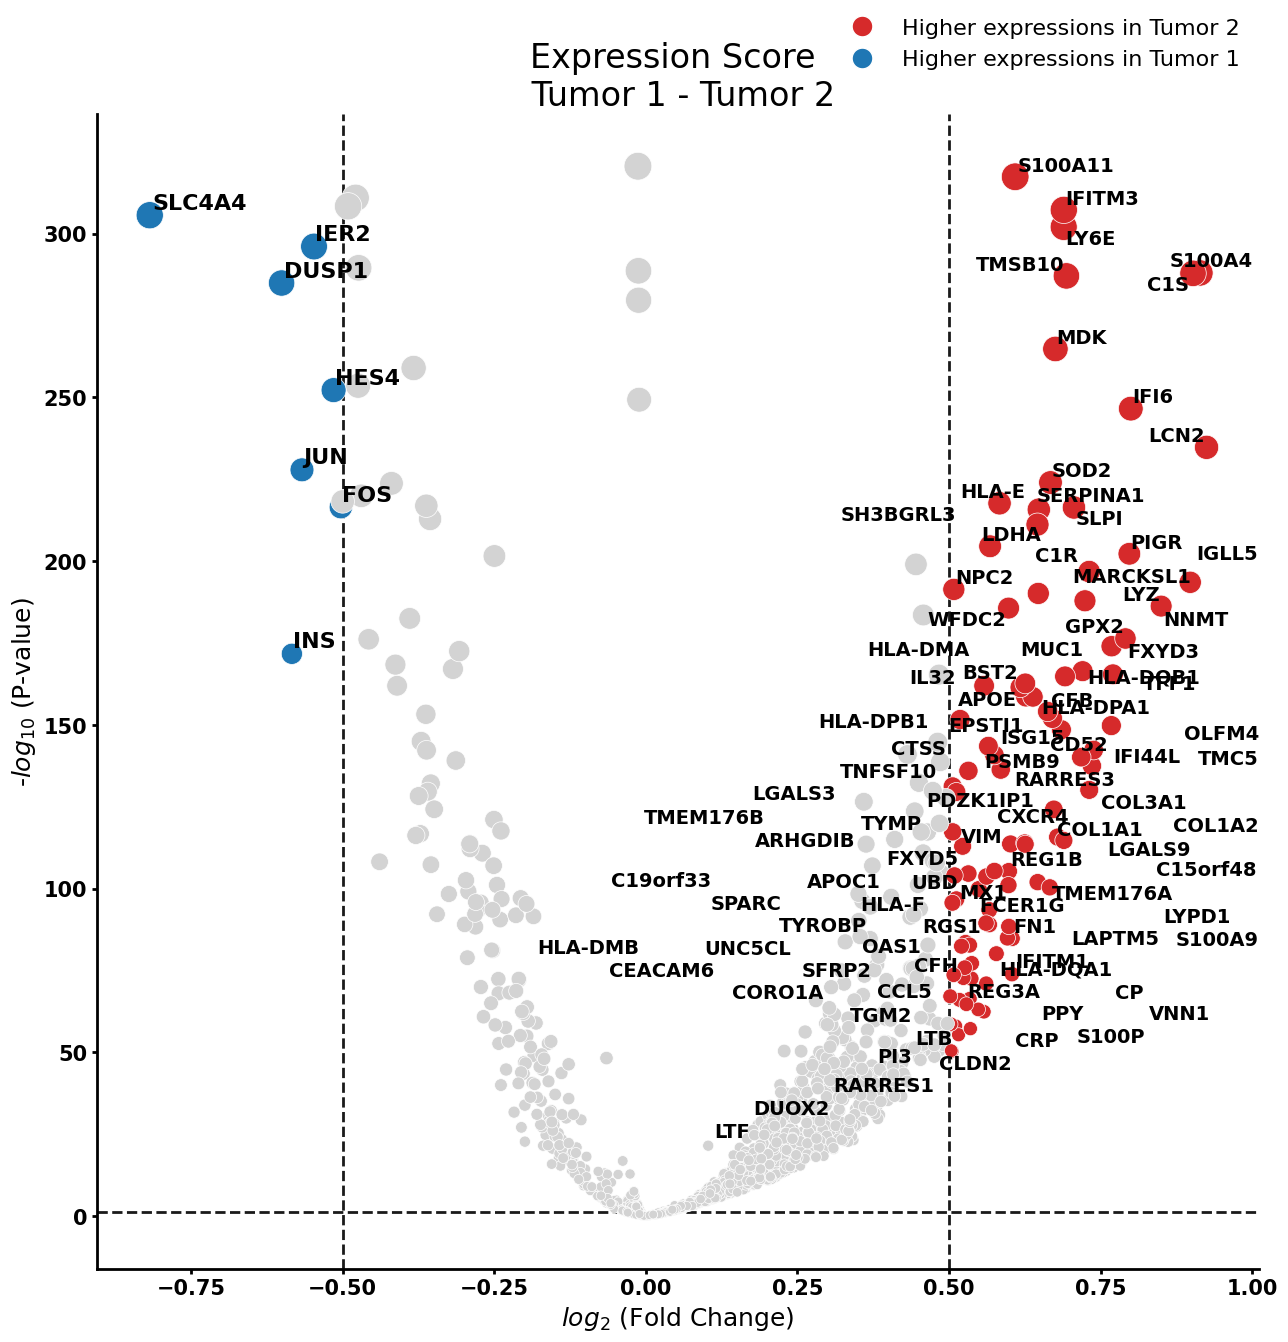

In [13]:
cell_type = "Ductal cell type 1" #look at the Cells folder
compute_diff_expressions(cell_type, proportion_df, path_to_result = path_to_results,
                         fc_thr = 0.5, pval_thr = 0.05,
                         group1 = 'Tumor 1', group2 = 'Tumor 2')

<h2 style="font-weight: 300;font-size: 32px;"> Gene Ontology analysis</h2>

Based on the adjusted p-value and fold change threshold, we select genes that are highly differentiated in each patient sub-groups and specify their annotation using the <a href="https://biit.cs.ut.ee/gprofiler/gost">gProfiler</a>

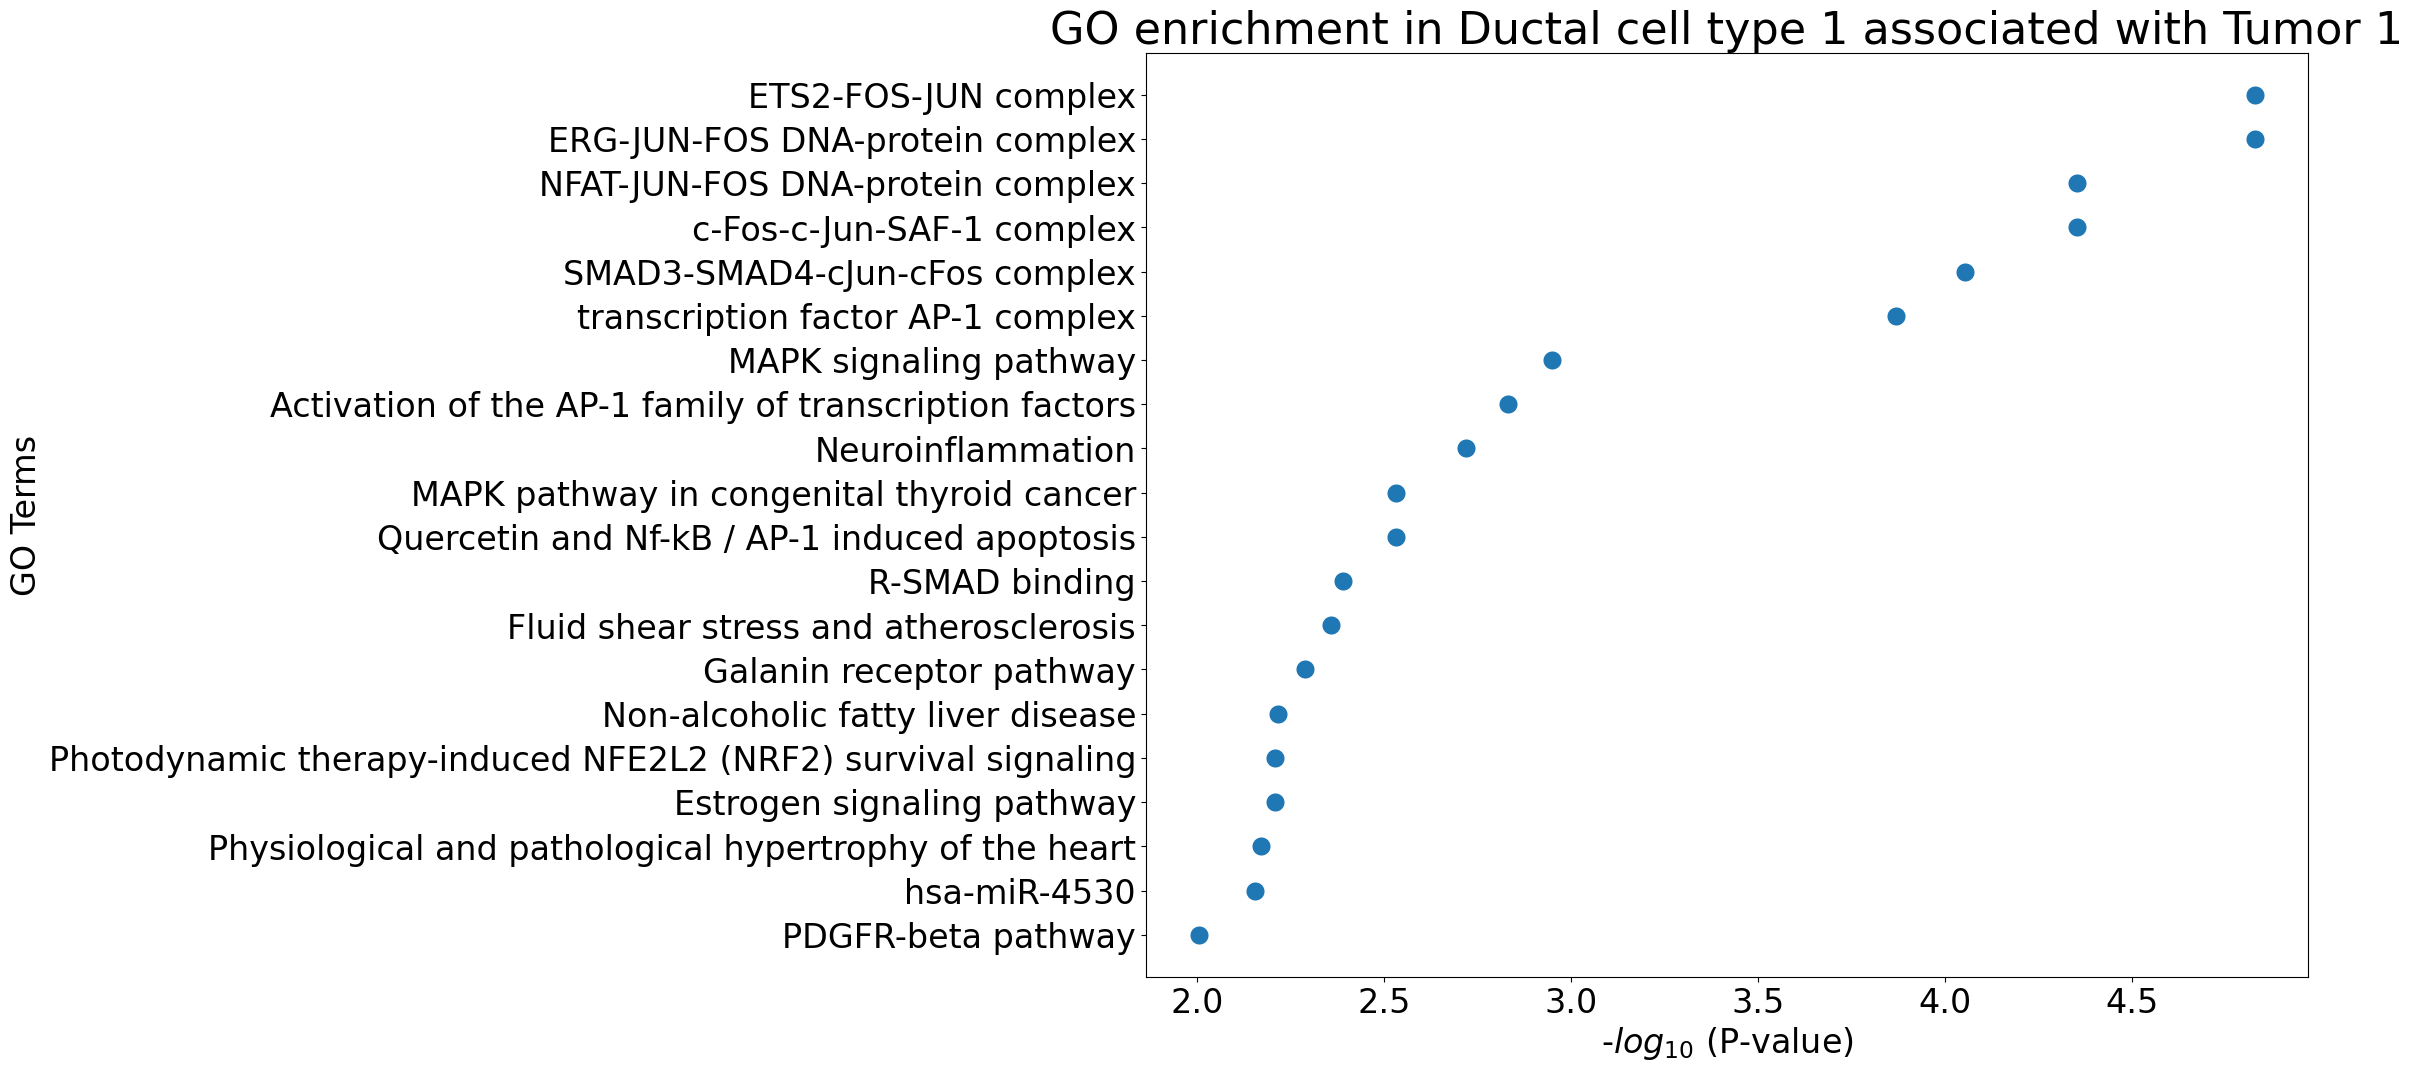

In [14]:
gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 1',
                                   path_to_results = path_to_results)

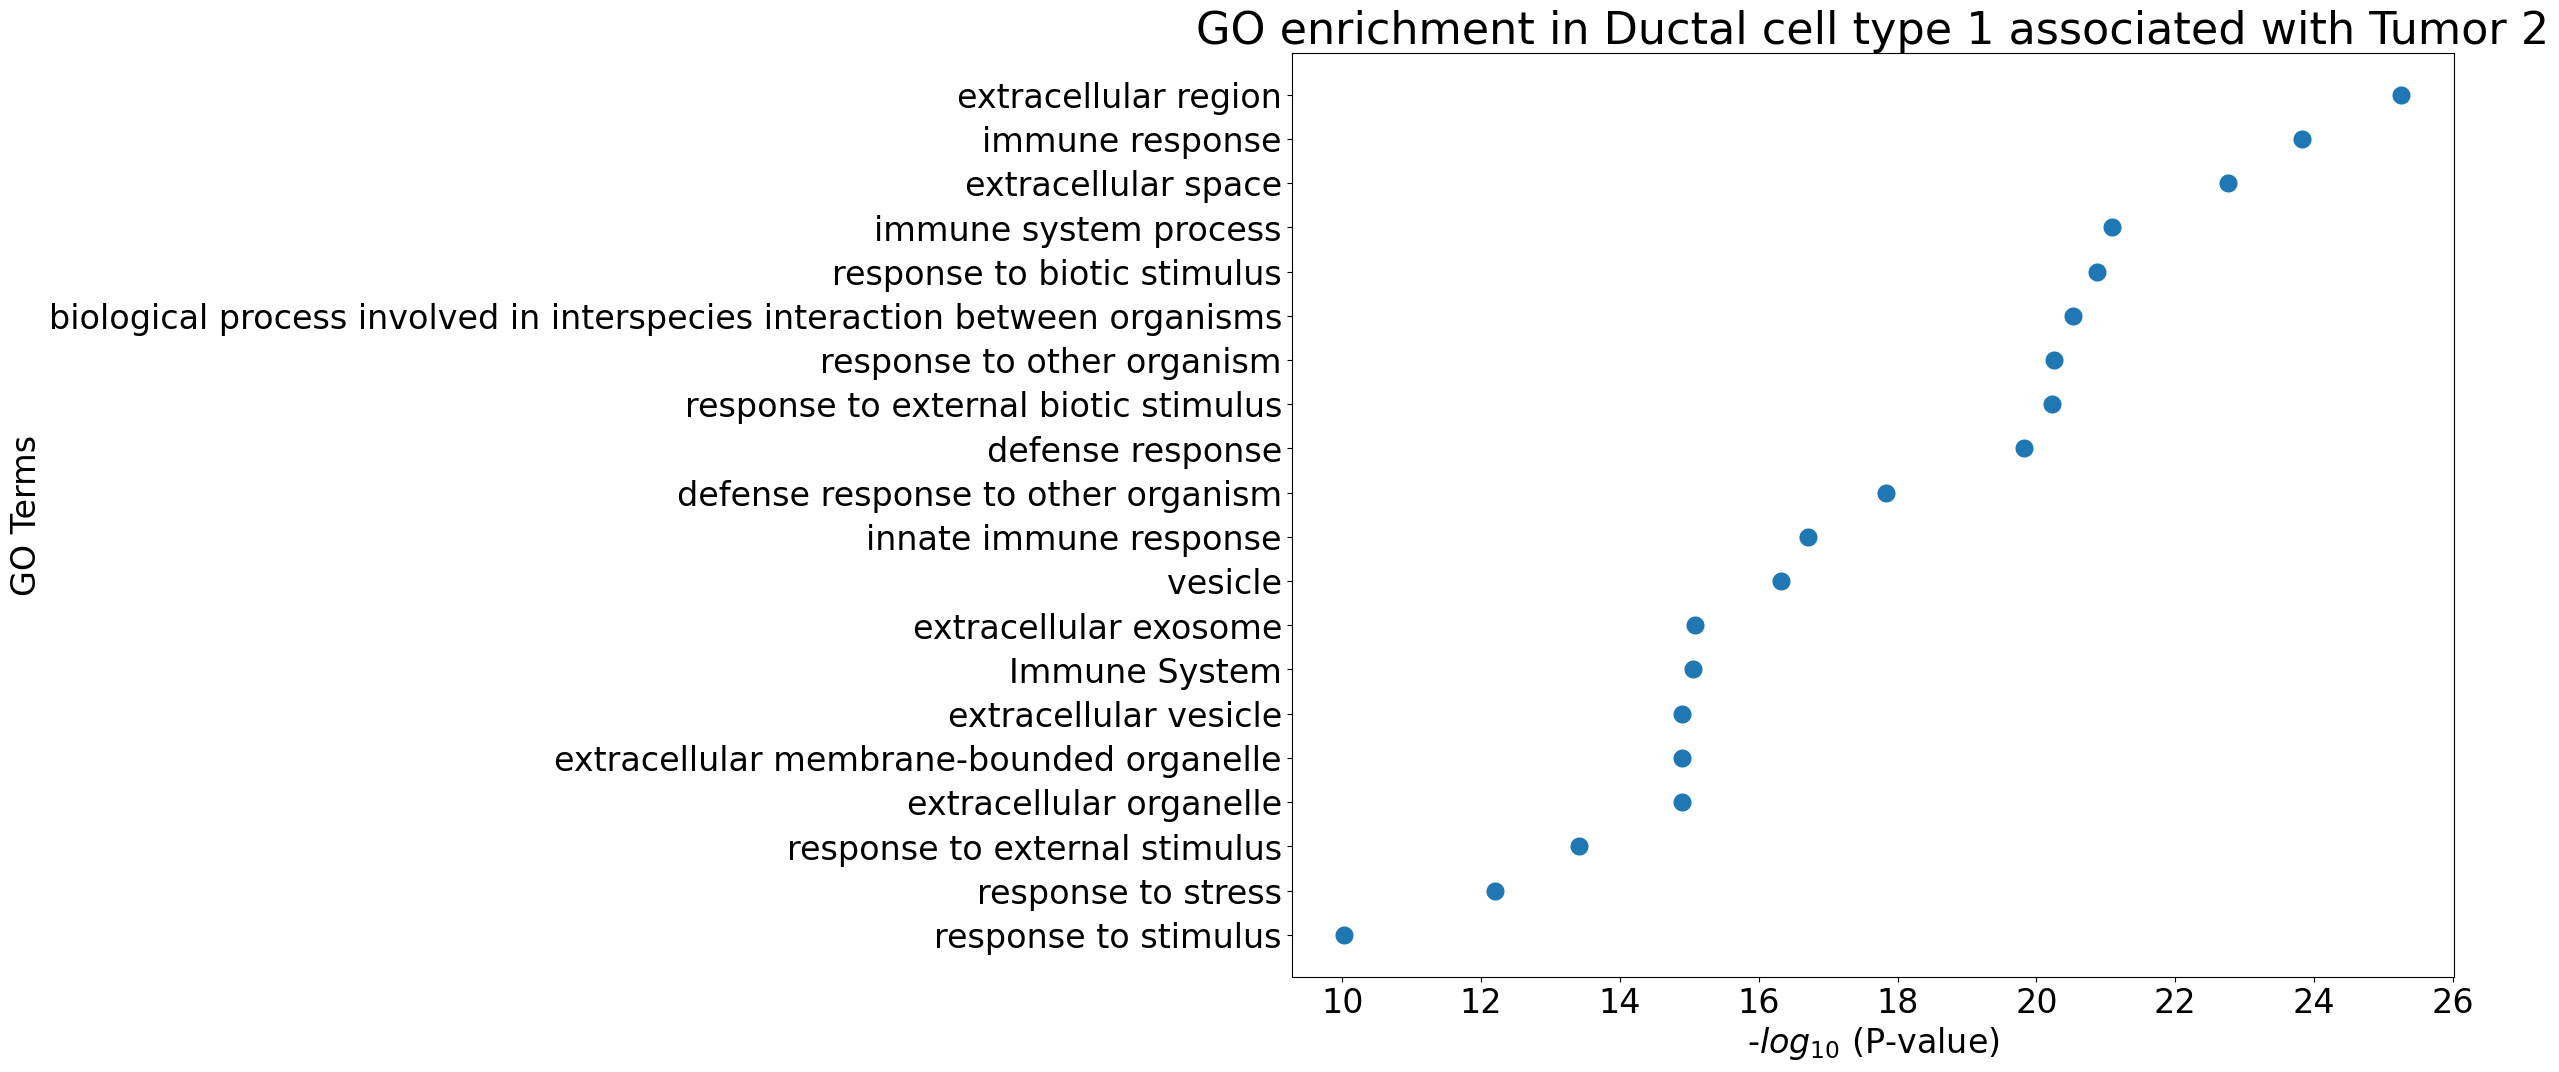

In [15]:
gene_annotation_cell_type_subgroup(cell_type = cell_type, group = 'Tumor 2',
                                   path_to_results = path_to_results)